## Método de colocación con PyTorch


A continuación se implementará el método de colocación utilizando un optimizador y la función de autodiferenciación de PyTorch. 

In [69]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

## Función de aproximación propuesta

Utilizando una aproximación a la solución de la siguiente forma

$$u_N(x) = \sum_{i=0}^N c_i \phi_i(x) = x (1-x) \sum_{i=0}^N c_i x^i\, ,$$

en donde vemos que esta función satisface las condiciones de frontera.

In [70]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (1 - x) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)


Y el residual estaría dado por

$$R = \frac{d^2 u_N}{dx^2} + u_N + x\, .$$

Considerando el caso de N=3, tenemos que:

$$
-c_0 x^2 + c_0 x - 2c_0 - c_1 x^3 + c_1 x^2 - 6c_1 x + 2c_1 - c_2 x^4 + c_2 x^3 - 12c_2 x^2 + 6c_2 x - c_3 x^5 + c_3 x^4 - 20c_3 x^3 + 12c_3 x^2 + x
$$

In [71]:
def residuo(x, c):
    terms = [
        -c[0]*x**2 + c[0]*x - 2*c[0],
        -c[1]*x**3 + c[1]*x**2 - 6*c[1]*x + 2*c[1],
        -c[2]*x**4 + c[2]*x**3 - 12*c[2]*x**2 + 6*c[2]*x,
        -c[3]*x**5 + c[3]*x**4 - 20*c[3]*x**3 + 12*c[3]*x**2
    ]
    return sum(terms) + x

### Optimización de coeficientes

Optimización de cuatro coeficientes para cuatro valores de $x$.

In [72]:
x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True) 

def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

c = initialize_coefficients(4).requires_grad_(True)

def loss_fn(x, c):
    y = residuo(x, c)
    loss = torch.mean(y ** 2)  # Mean squared error
    return loss

optimizer = torch.optim.Adam([c], lr=0.1)

for epoch in range(1_000):  # Number of iterations
    optimizer.zero_grad()  # Clear previous gradients
    loss = loss_fn(x, c)  # Compute loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters
    
    if epoch % 100 == 0:  # Print progress every 1000 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}, c: {c.data}')

print(f'Optimized c: {c.data}')

Epoch 0, Loss: 3.281515598297119, c: tensor([ 0.2490,  0.8849, -1.1225, -0.5345])
Epoch 100, Loss: 0.0022876248694956303, c: tensor([ 0.1313,  0.5261, -0.6840,  0.4306])
Epoch 200, Loss: 0.0018382348353043199, c: tensor([ 0.1402,  0.4919, -0.6209,  0.3899])
Epoch 300, Loss: 0.001411276520229876, c: tensor([ 0.1462,  0.4543, -0.5452,  0.3405])
Epoch 400, Loss: 0.0010226634331047535, c: tensor([ 0.1524,  0.4147, -0.4655,  0.2885])
Epoch 500, Loss: 0.0007020892226137221, c: tensor([ 0.1586,  0.3759, -0.3874,  0.2375])
Epoch 600, Loss: 0.0004574880877044052, c: tensor([ 0.1643,  0.3398, -0.3147,  0.1900])
Epoch 700, Loss: 0.0002831442398019135, c: tensor([ 0.1695,  0.3075, -0.2498,  0.1476])
Epoch 800, Loss: 0.00016644525749143213, c: tensor([ 0.1739,  0.2798, -0.1939,  0.1111])
Epoch 900, Loss: 9.288406727137044e-05, c: tensor([ 0.1775,  0.2567, -0.1475,  0.0808])
Optimized c: tensor([ 0.1805,  0.2383, -0.1105,  0.0566])


Gráfica de la predición obtenido.

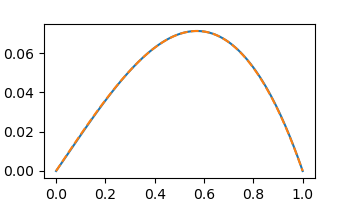

In [73]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
y_true.detach().numpy()
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

Gráfica del residuo obtenido luego de la optimización.

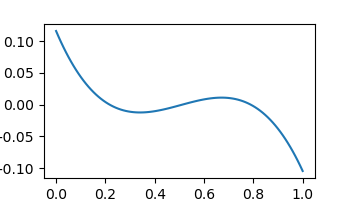

In [74]:
x.requires_grad_(True)
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x.detach().numpy(),residuo(x, c).detach().numpy())
plt.show()

Cálculo del error relativo.

In [75]:
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

0.003548479

## Utilizando diferenciación automática


En lugar de calcular el residuo análiticamente se obtiene con diferenciación automática.

In [76]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (1 - x) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)

def derivative(dy, x, order=1):
    for _ in range(order):
        dy = torch.autograd.grad(dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]
    return dy

def residuo(x, c):
    return derivative(funcion_aprox(x, c), x, order=2) + funcion_aprox(x, c) + x

def loss_fn(x, c):
    y = residuo(x, c)
    return torch.mean(y ** 2)  # Error cuadrático medio

# Configuración de datos y parámetros
x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True)

# Inicialización de coeficientes utilizando Xavier
def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

# Configuración del optimizador
c = initialize_coefficients(4).requires_grad_(True)

In [81]:
# Configuración del optimizador
optimizer = torch.optim.Adam([c], lr=0.1)

# Bucle de entrenamiento
num_epochs = 1_000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Limpiar gradientes previos
    current_loss = loss_fn(x, c)  # Calcular la pérdida
    current_loss.backward()  # Calcular gradientes
    optimizer.step()  # Actualizar parámetros

    if epoch % 100 == 0:  # Mostrar progreso cada 1000 épocas
        print(f'Epoch {epoch}, Loss: {current_loss.item()}, c: {c.data}')

# Resultados optimizados
print(f'Optimized c: {c.data}') 

Epoch 0, Loss: 2.353443233005237e-05, c: tensor([ 0.2873,  0.0952, -0.1236, -0.1001])
Epoch 100, Loss: 8.484727914037649e-06, c: tensor([ 0.1878,  0.1898, -0.0137, -0.0065])
Epoch 200, Loss: 1.4986976992759082e-08, c: tensor([ 0.1884,  0.1886, -0.0106, -0.0085])
Epoch 300, Loss: 1.3427731815340849e-08, c: tensor([ 0.1884,  0.1885, -0.0105, -0.0086])
Epoch 400, Loss: 1.3427316147840429e-08, c: tensor([ 0.1884,  0.1885, -0.0105, -0.0086])
Epoch 500, Loss: 1.3427752243444502e-08, c: tensor([ 0.1884,  0.1885, -0.0105, -0.0086])
Epoch 600, Loss: 1.3426914691194725e-08, c: tensor([ 0.1884,  0.1885, -0.0105, -0.0086])
Epoch 700, Loss: 1.342737476761613e-08, c: tensor([ 0.1884,  0.1885, -0.0105, -0.0086])
Epoch 800, Loss: 1.3426954659223611e-08, c: tensor([ 0.1884,  0.1885, -0.0105, -0.0086])
Epoch 900, Loss: 1.3427658096532014e-08, c: tensor([ 0.1884,  0.1885, -0.0105, -0.0086])
Optimized c: tensor([ 0.1884,  0.1885, -0.0105, -0.0086])


Gráfica de la predicción obtenida.

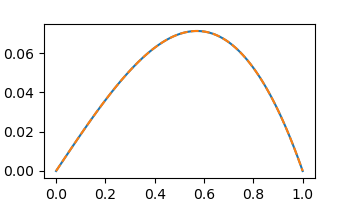

In [78]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

Gráfica el residuo obtenido luego de la optimización.

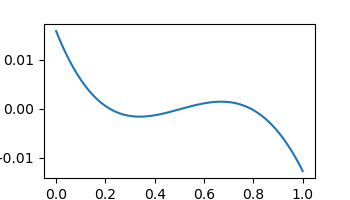

In [79]:
x.requires_grad_(True)
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x.detach().numpy(),residuo(x, c).detach().numpy())
plt.show()

Cálculo del error relativo para la apróximación con diferenciación automática.

In [80]:
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

0.0004636762